**In the notebook, We'll detect head of the wheat**

<img src='https://i.ytimg.com/vi/yqvMuw-uedU/maxresdefault.jpg' height=500 width=800/>

# Firstly we'll preprocess the dataset in suitable format for YOLOv5.
The format should look like this:

    - converter(main directory)
        - val
            - labels (contains all the box dimensions)
            - images (contains images)
        - train
            - labels
            - images

In [1]:
# Importing Required packages
import os
import torch
import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import shutil as sh

import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
%matplotlib inline

In [2]:
# Reading the dataframe
df = pd.read_csv('../input/global-wheat-detection/train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [3]:
# read the training data.

df = pd.read_csv('../input/global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = (df['x'] + df['w'])/2
df['y_center'] = (df['y'] + df['h'])/2
df['classes'] = 0

# Making new dataframe, suitable to make suitable dataset for yolov5
df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,445.0,129.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,178.0,303.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,225.5,332.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,471.5,101.0,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,75.0,130.5,0


In [4]:
index = list(set(df.image_id))
print("Total Images: ",len(index))

Total Images:  3373


In [5]:
# This cell will automatically make the dataset and save it to convertor folder
source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val/'
            else:
                path2save = 'train/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("../input/global-wheat-detection/{}/{}.jpg".format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))
    
# Bases on this notebook: https://www.kaggle.com/orkatz2/yolov5-train

  0%|          | 0/3373 [00:00<?, ?it/s]

In [6]:
# Cloning the repo
!git clone https://github.com/ultralytics/yolov5.git
clear_output()

In [7]:
# Moving the folders to our working directory
!mv ./yolov5/* ./

In [8]:
# Checking if the files correctly cloned and moved
!ls

CONTRIBUTING.md		   convertor   models		 utils
Dockerfile		   data        requirements.txt  val.py
LICENSE			   detect.py   setup.cfg	 yolov5
README.md		   export.py   train.py
__notebook_source__.ipynb  hubconf.py  tutorial.ipynb


In [9]:
# installing the requirements file
!pip install -r requirements.txt
clear_output()

In [10]:
#customize iPython writefile so we can write variables

from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [11]:
# Our image and annotation files are saved into this directory

print(os.listdir("./convertor/fold0"))

['labels', 'images']


In [12]:
# Making a directory for storing our data.yaml and custom YOLOv5(..).yml files
!mkdir DataFile

In [13]:
%%writetemplate ./DataFile/data.yaml

train: ./convertor/fold0/images/train # training directory
val: ./convertor/fold0/images/val # validation directory
test: ./convertor/fold0/images/val # I'll use validation directory for test image
nc: 1 # number of class
names: ['Wheat'] # name of the class

Our models structure files are save here. These are used for training [coco dataset](https://cocodataset.org/#home). But for using for our custom dataset, we have to change the nc parameter to 1, insted of 80.

In [14]:
print(os.listdir("./models"))

['common.py', 'yolov5s.yaml', 'hub', 'yolov5l.yaml', 'yolo.py', 'yolov5n.yaml', 'yolov5x.yaml', 'tf.py', '__init__.py', 'experimental.py', 'yolov5m.yaml']


In [15]:
# checking the yolov5s model architecture
!cat ./models/yolov5.yaml

cat: ./models/yolov5.yaml: No such file or directory


Modifying the yolov5s model architecture for nc: 1

In [16]:
%%writetemplate ./DataFile/customYOLOv5x.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 1.33  # model depth multiple
width_multiple: 1.25  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

With our __data.yaml__ and __custom_yolov5s.yaml__ files ready to go we are ready to train!

To kick off training we running the training command with the following options:

- ```img```: define input image size
- ```batch```: determine batch size
- ```epochs```: define the number of training epochs.
- ```data```: set the path to our yaml file
- ```cfg```: specify our model configuration
- ```weights```: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
- ```name```: result names
- ```cache```: cache images for faster training
- ```evolve```: evolve hyperparameters

In [17]:
# You should skip this line
!wandb off

W&B offline, running your script from this directory will only write metadata locally.


In [18]:
%%time
!python train.py --img 640  --batch 16 --epochs 1 --data ./DataFile/data.yaml --cfg ./DataFile/customYOLOv5x.yaml --weights yolov5x.pt  --name Result --cache

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
2021-11-21 11:31:38.349382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-21 11:31:42.894630: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-21 11:31:42.897039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
100%|██████████| 166M/166M [00:00<00:00, 235MB/s] 

train: Scanning 'convertor/fold0/labels/train' images and labels...2699 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 2699/2699 [00:01<00:00, 1389.57it/s]
train: Caching images (3.3GB ram): 100%|██████████| 2699/2699 [00:41<00:00, 65.40it/s]
val: Scanning 'convertor/fol

# Training is completed.
Results are saved in ./runs/train directory

In [39]:
# let's check the training result directory.
# Here model and result are saved
!ls -R ./runs/train

./runs/train:
FineTuned  Result

./runs/train/FineTuned:
events.out.tfevents.1637494892.dd97f402e46c.588.0  labels_correlogram.jpg
hyp.yaml					   opt.yaml
labels.jpg					   weights

./runs/train/FineTuned/weights:

./runs/train/Result:
F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1637494301.dd97f402e46c.130.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights

./runs/train/Result/weights:
best.pt  last.pt


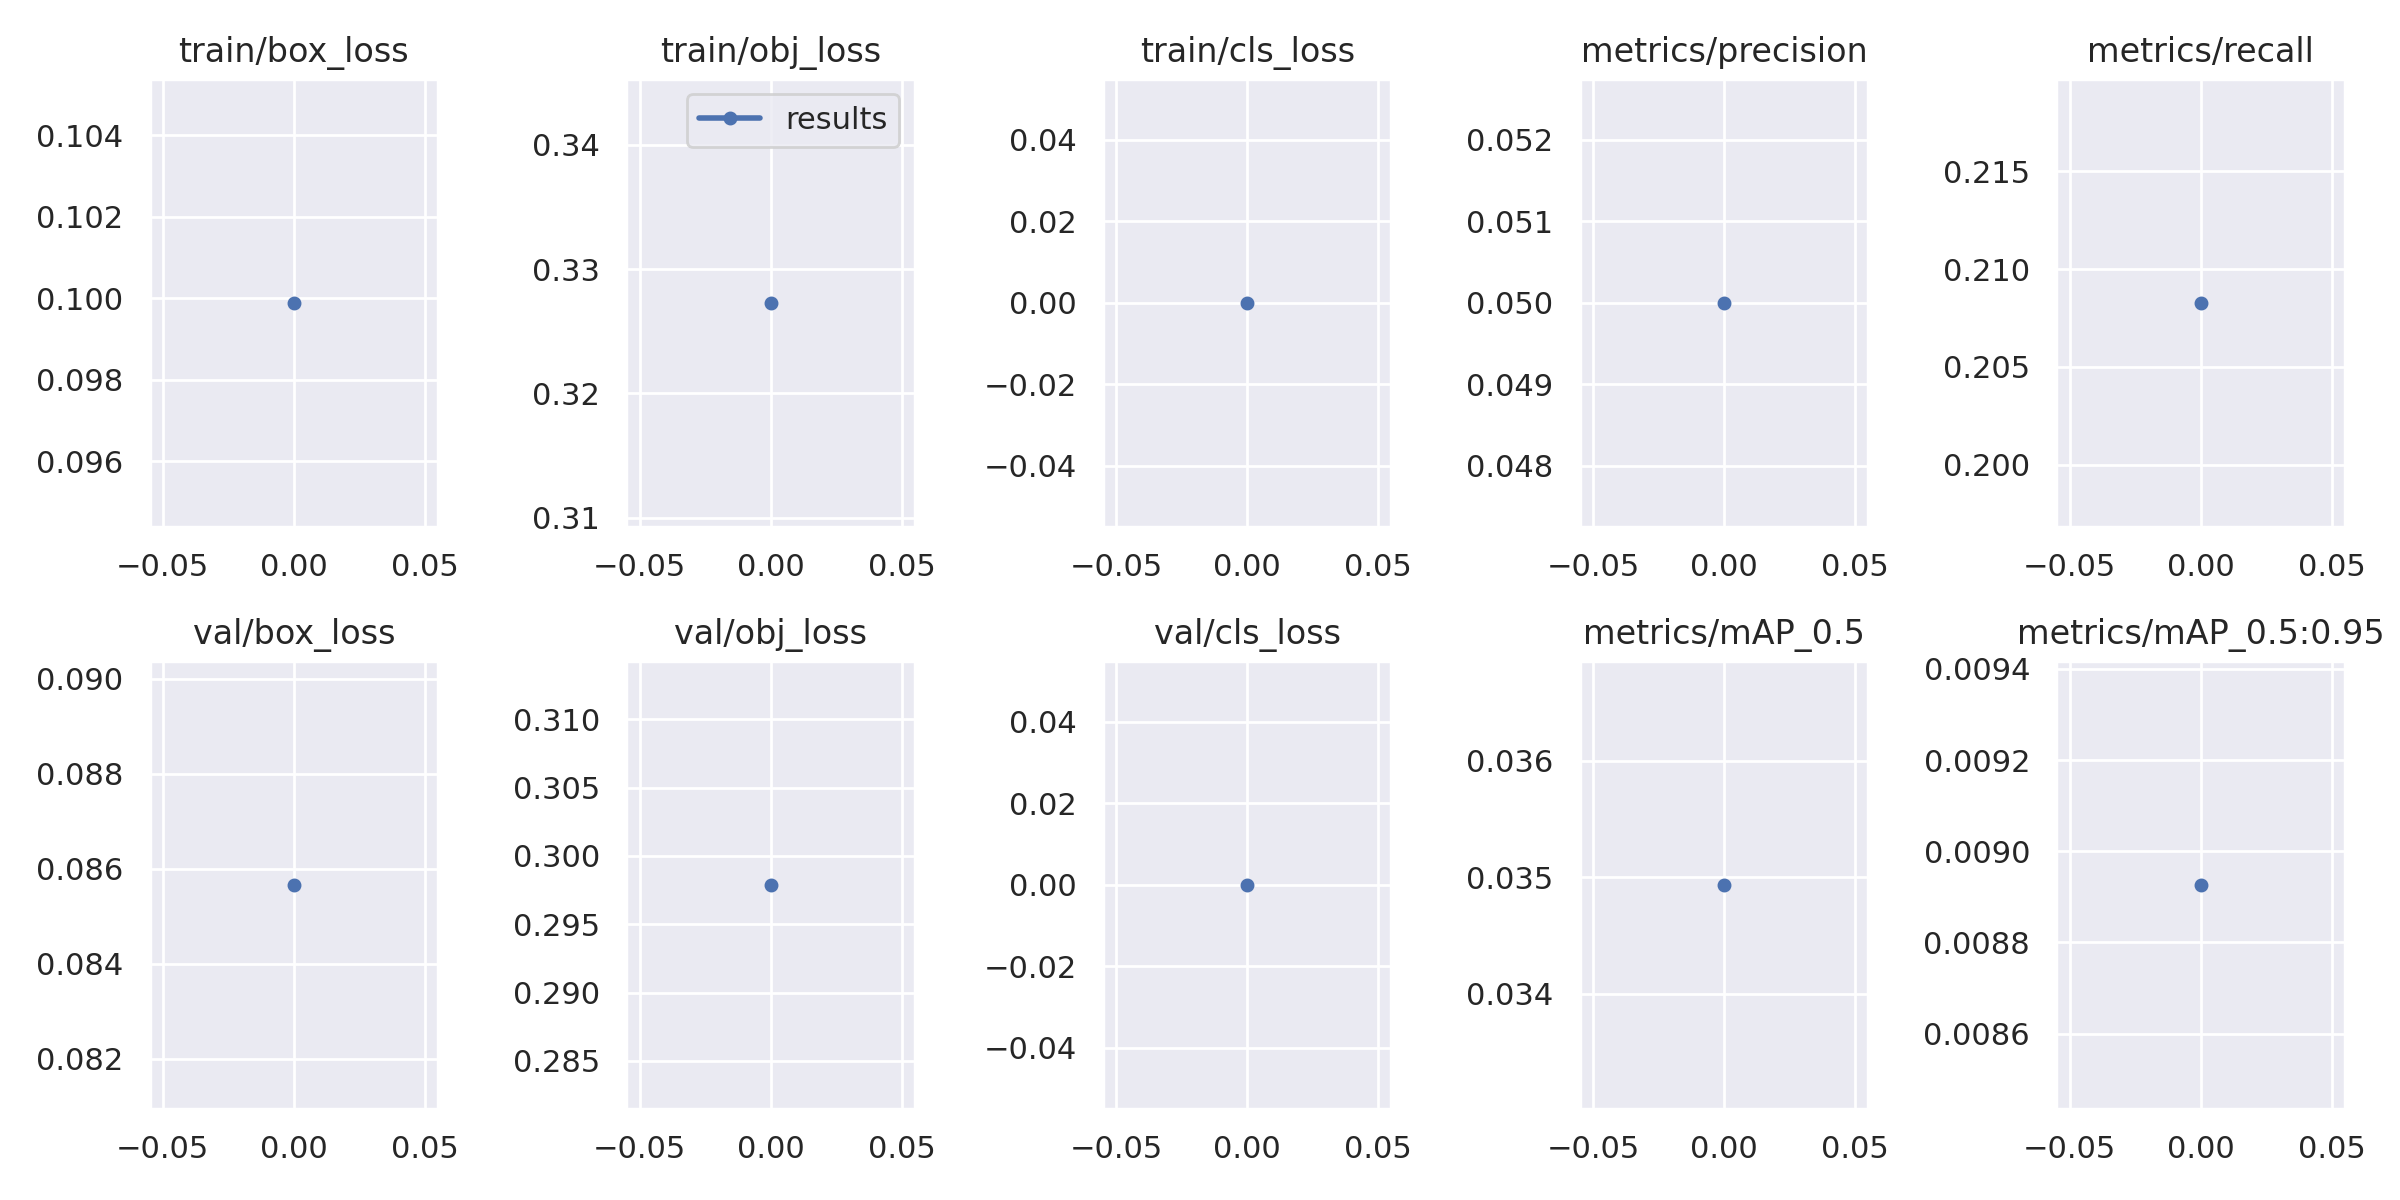

In [40]:
# Analize the training and validation result
Image('./runs/train/Result/results.png')

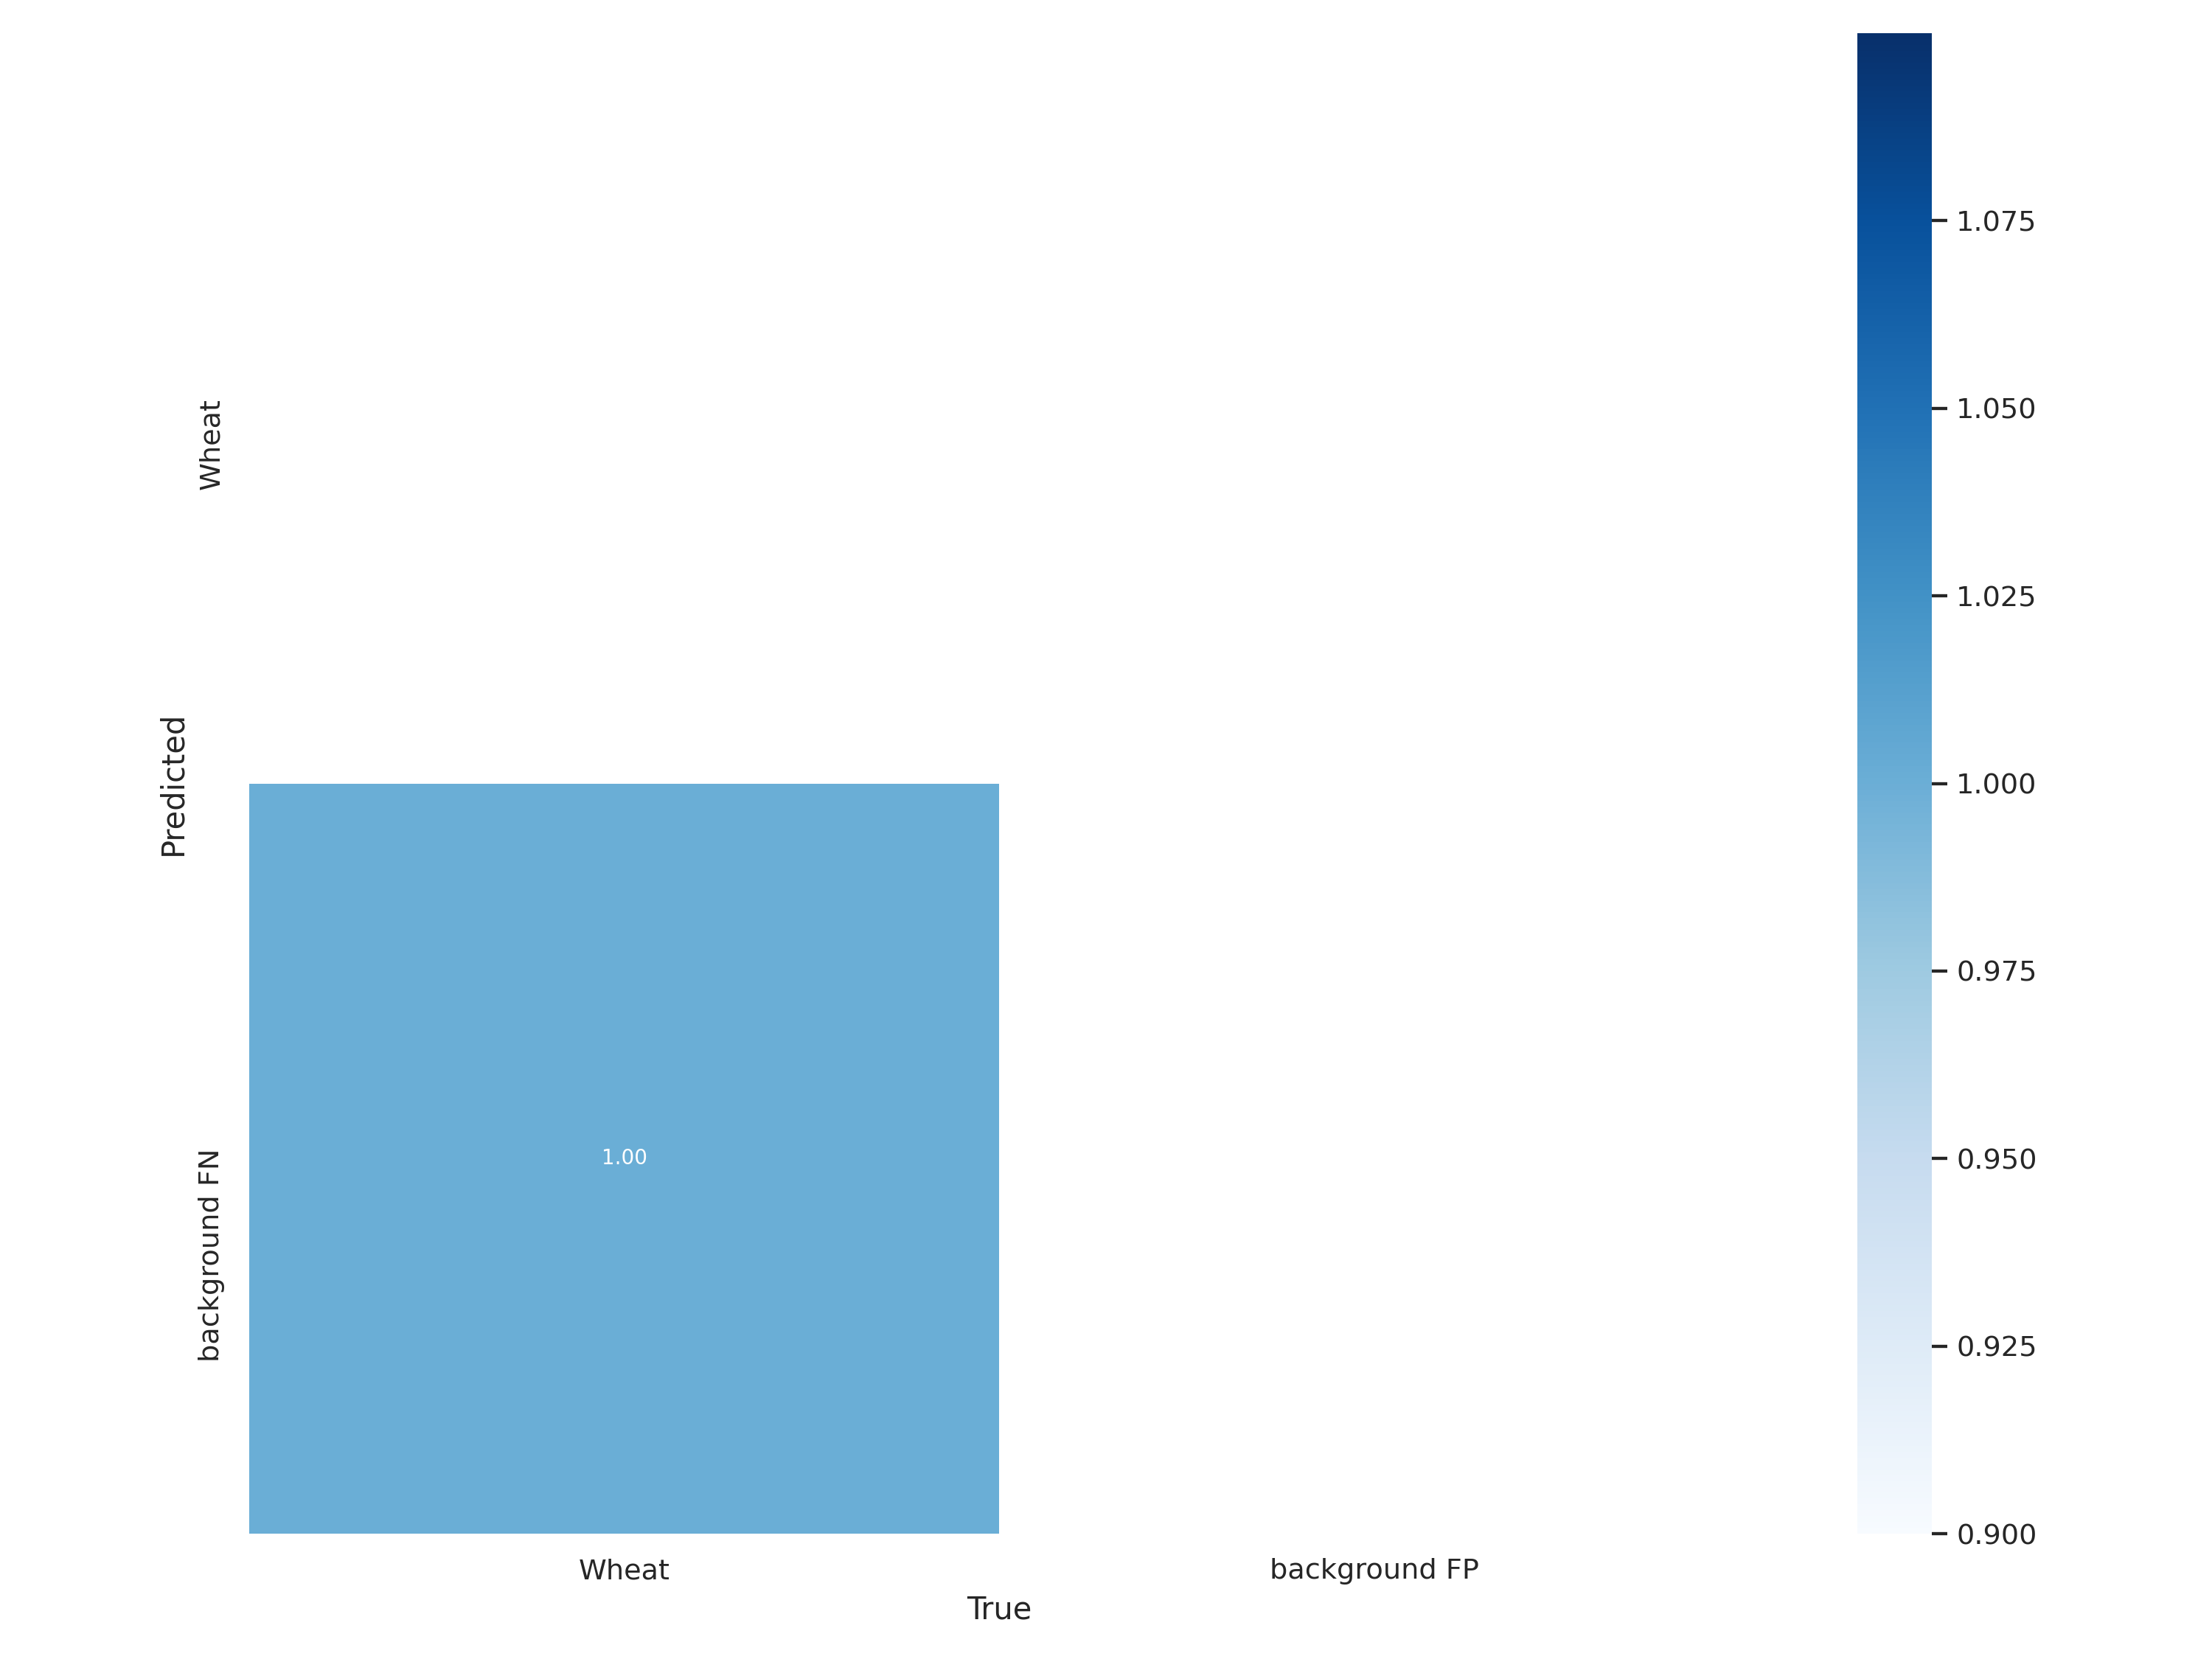

In [41]:
# Analize the Confusion matrix
Image('./runs/train/Result/confusion_matrix.png',width=400)

In [42]:
!python detect.py --img-size 800  --conf 0.2 --source ../input/global-wheat-detection/test --weights ./runs/train/Result/weights/best.pt --augment 

In [43]:
# Detected images/video are saved in this path
!ls -R runs/detect

runs/detect:
exp  exp2  exp3

runs/detect/exp:
2fd875eaa.jpg  51b3e36ab.jpg  53f253011.jpg  aac893a91.jpg  cc3532ff6.jpg
348a992bb.jpg  51f1be19e.jpg  796707dd7.jpg  cb8d261a3.jpg  f5a1f0358.jpg

runs/detect/exp2:

runs/detect/exp3:
2fd875eaa.jpg  51b3e36ab.jpg  53f253011.jpg  aac893a91.jpg  cc3532ff6.jpg
348a992bb.jpg  51f1be19e.jpg  796707dd7.jpg  cb8d261a3.jpg  f5a1f0358.jpg


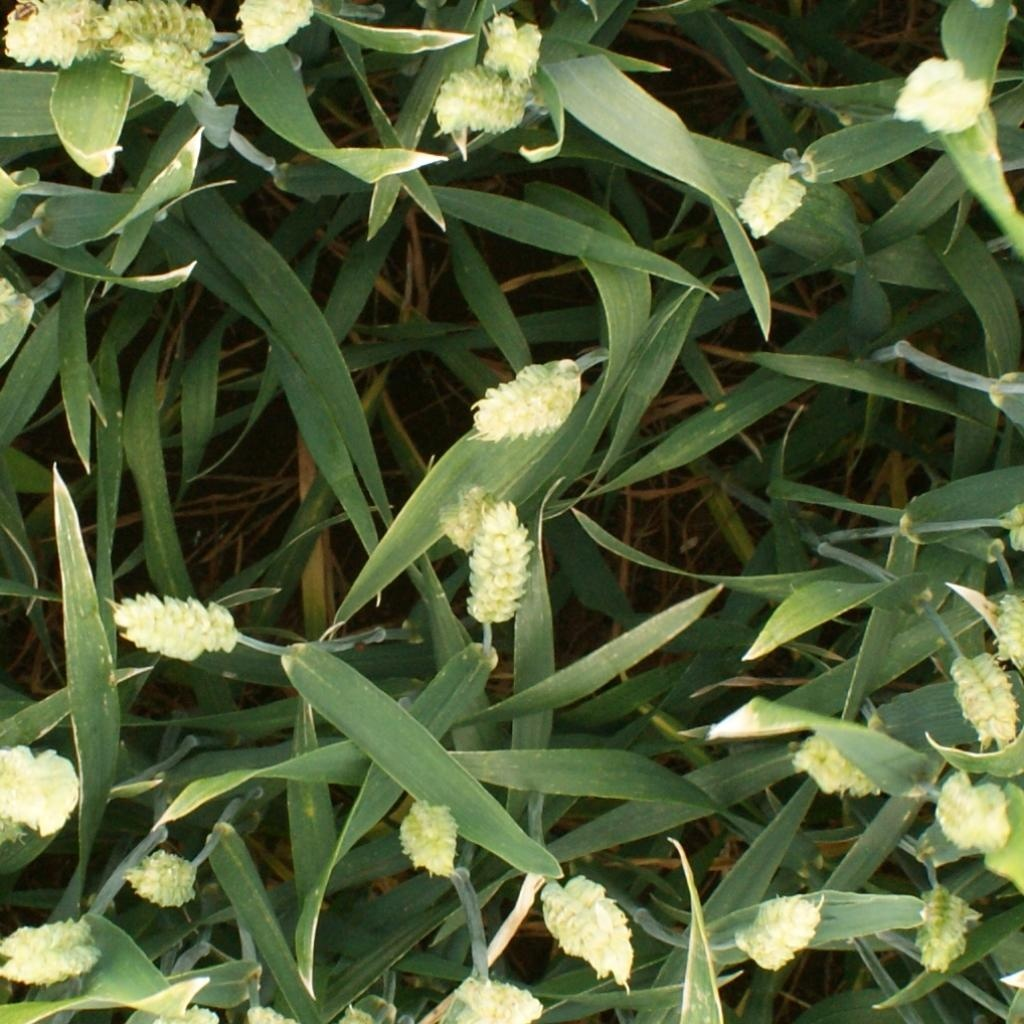

In [44]:
Image('runs/detect/exp/2fd875eaa.jpg',width=400)

In [25]:
# hyper parameters data are saved in this location
!ls ./data

Argoverse.yaml	      SKU-110K.yaml  coco.yaml	   images
GlobalWheat2020.yaml  VOC.yaml	     coco128.yaml  scripts
Objects365.yaml       VisDrone.yaml  hyps	   xView.yaml


**Let's train the model with better hyper parameter**

In [26]:
%cat ./data/hyp.finetune.yaml

cat: ./data/hyp.finetune.yaml: No such file or directory


In [27]:
%%writetemplate ./DataFile/hyp.custom.yaml

lr0: 0.0032
lrf: 0.12
momentum: 0.843
weight_decay: 0.00036
warmup_epochs: 2.0
warmup_momentum: 0.5
warmup_bias_lr: 0.05
box: 0.0296
cls: 0.243
cls_pw: 0.631
obj: 0.301
obj_pw: 0.911
iou_t: 0.2
anchor_t: 2.91
# anchors: 3.63
fl_gamma: 0.0   # 
hsv_h: 0.0138
hsv_s: 0.002
hsv_v: 0.2
degrees: 0.2
translate: 0.0
scale: 0.3
shear: 0.0
perspective: 0.0
flipud: 0.00856
fliplr: 0.5
mosaic: 1.0
mixup: 0.5

- ```--hyp```: Location of new custom hyper parameter

# I've used weight of previous trained model.So, this training will initilize from the best result(weight) of the previous model

In [28]:
%%time
!python train.py --img 1024  --batch 4 --epochs 1 --data ./DataFile/data.yaml --cfg ./DataFile/customYOLOv5x.yaml --hyp ./DataFile/hyp.custom.yaml  --weights ./runs/train/Result/weights/best.pt  --name FineTuned

github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
2021-11-21 11:41:31.266671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-21 11:41:33.685501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
2021-11-21 11:41:33.687966: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
train: Scanning 'convertor/fold0/labels/train.cache' images and labels... 2699 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 2699/2699 [00:00<?, ?it/s]
val: Scanning 'convertor/fold0/labels/val.cache' images and labels... 674 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 674/674 [00:00<?, ?it/s]
  0%|         

In [29]:
# new training result
os.listdir('./runs/train')

['FineTuned', 'Result']

In [30]:
!ls -R ./runs/train/FineTuned

./runs/train/FineTuned:
events.out.tfevents.1637494892.dd97f402e46c.588.0  labels_correlogram.jpg
hyp.yaml					   opt.yaml
labels.jpg					   weights

./runs/train/FineTuned/weights:


# Model Ensembling
I've used two models during detection. It'll increase detection result.

In [31]:
!python detect.py  --img 800 --weights ./runs/train/Result/weights/best.pt ./runs/train/FineTuned/weights/best.pt --source ../input/global-wheat-detection/test

Traceback (most recent call last):
  File "detect.py", line 244, in <module>
    main(opt)
  File "detect.py", line 239, in main
    run(**vars(opt))
  File "/opt/conda/lib/python3.7/site-packages/torch/autograd/grad_mode.py", line 26, in decorate_context
    return func(*args, **kwargs)
  File "detect.py", line 79, in run
    model = DetectMultiBackend(weights, device=device, dnn=dnn)
  File "/kaggle/working/models/common.py", line 305, in __init__
    model = torch.jit.load(w) if 'torchscript' in w else attempt_load(weights, map_location=device)
  File "/kaggle/working/models/experimental.py", line 96, in attempt_load
    ckpt = torch.load(attempt_download(w), map_location=map_location)  # load
  File "/opt/conda/lib/python3.7/site-packages/torch/serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/opt/conda/lib/python3.7/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/

In [32]:
!ls runs/detect

exp  exp2


In [33]:
!ls -R runs/detect/exp

runs/detect/exp:
2fd875eaa.jpg  51b3e36ab.jpg  53f253011.jpg  aac893a91.jpg  cc3532ff6.jpg
348a992bb.jpg  51f1be19e.jpg  796707dd7.jpg  cb8d261a3.jpg  f5a1f0358.jpg


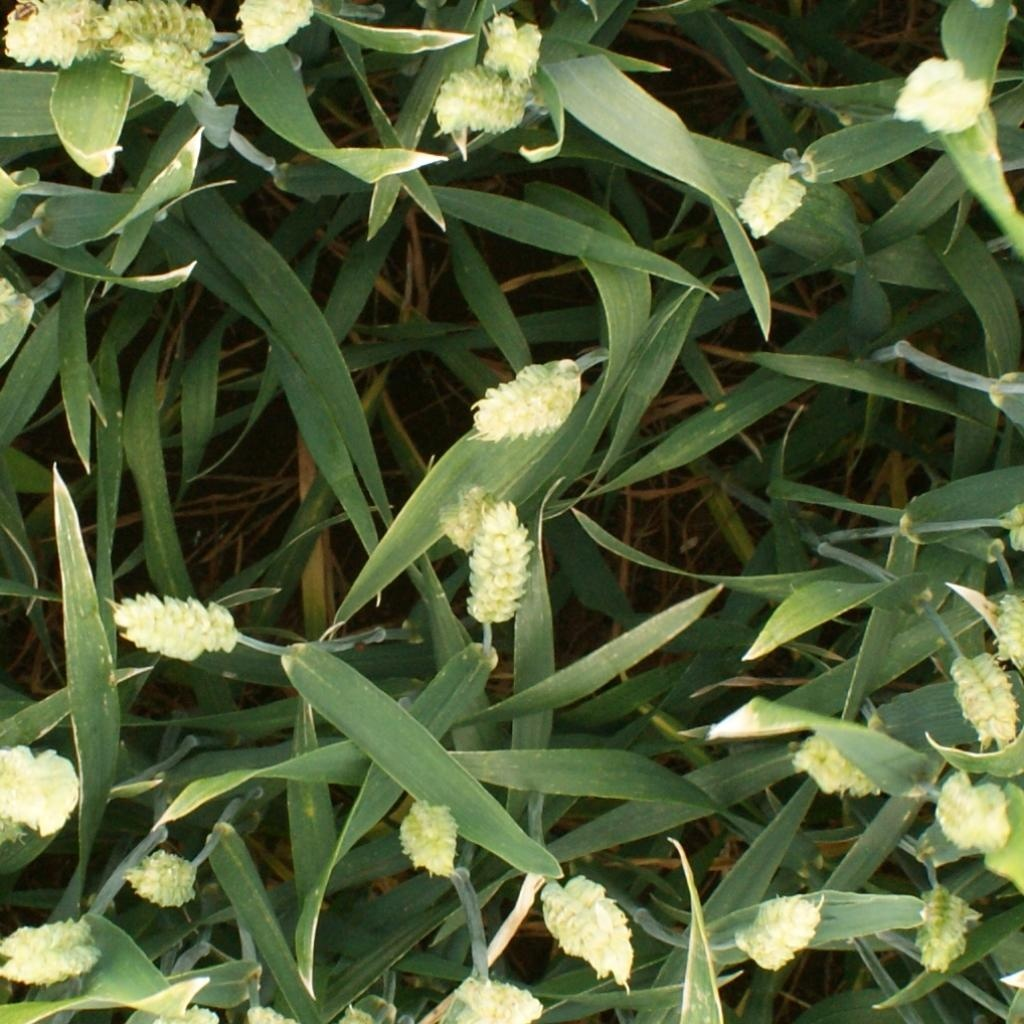

In [34]:
Image('runs/detect/exp/2fd875eaa.jpg', width=400)

# TTA(Test Time Augmentation) and Model Ensembling

In [35]:
!python test.py --weights ./runs/train/Result/weights/best.pt ./runs/train/FineTuned/weights/best.pt --data ./DataFile/data.yaml --img 800 --augment

python: can't open file 'test.py': [Errno 2] No such file or directory


In [36]:
!ls -R runs/test/exp

ls: cannot access 'runs/test/exp': No such file or directory


In [37]:
# That's all for today, I'll update the notebook for pseudo labelling soon.
# Please let me know if you face any issue or want have any confusion